In [7]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import collections
import math

In [8]:
sample_rate = 1e4
duration = 0.04
tone_freq = 2e3
samples_to_plot = 100

In [9]:
class Waveform:
    def __init__(self, t0, dt, y):
        self.t0 = t0
        self.dt = dt
        self.y = y

    def sample_times(self):
        begin = self.t0
        end = self.t0 + self.dt * len(self.y)
        return np.arange(begin, end, self.dt)
    
    def __add__(self, other):
        return Waveform(self.t0, self.dt, self.y + other.y)
    
class Spectrum:
    def __init__(self, f0, df, y):
        self.f0 = f0
        self.df = df
        self.y = y
        
    def frequency_bins(self):
        begin = self.f0
        end = self.f0 + self.df * len(self.y)
        return np.arange(begin, end, self.df)

In [10]:
def create_single_tone(sample_rate, duration, tone_freq):
    dt = 1/sample_rate
    t = np.arange(0, duration, dt)
    tone = np.exp(1.0j*(2*np.pi*tone_freq*t))
    return Waveform(0, dt, tone)

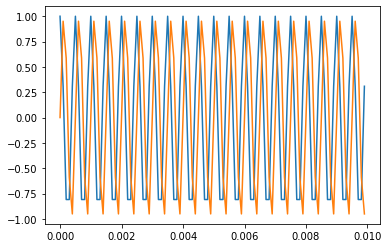

In [11]:
tone = create_single_tone(sample_rate, duration, tone_freq)
time_axis = tone.sample_times()
plt.plot(time_axis[:samples_to_plot], np.real(tone.y)[:samples_to_plot])
plt.plot(time_axis[:samples_to_plot], np.imag(tone.y)[:samples_to_plot])

In [12]:
def create_noise_signal(sample_rate, duration, amplitude):
    real = np.random.normal(0, amplitude, int(round(sample_rate*duration)))
    cplx = np.random.normal(0, amplitude, int(round(sample_rate*duration)))
    return Waveform(0, 1.0/sample_rate, real + 1.0j*cplx)

In [13]:
noise = create_noise_signal(sample_rate, duration, 0.01)

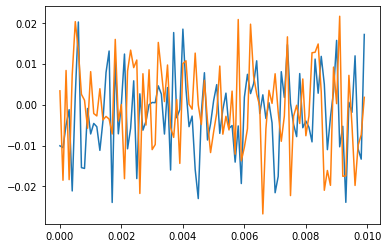

In [14]:
plt.plot(time_axis[:samples_to_plot], np.real(noise.y)[:samples_to_plot])
plt.plot(time_axis[:samples_to_plot], np.imag(noise.y)[:samples_to_plot])

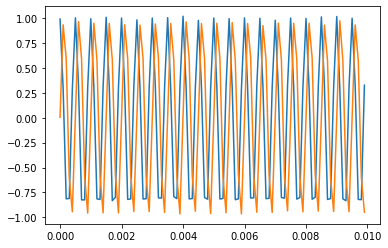

In [15]:
wfm = tone + noise
plt.plot(time_axis[:samples_to_plot], np.real(wfm.y)[:samples_to_plot])
plt.plot(time_axis[:samples_to_plot], np.imag(wfm.y)[:samples_to_plot])

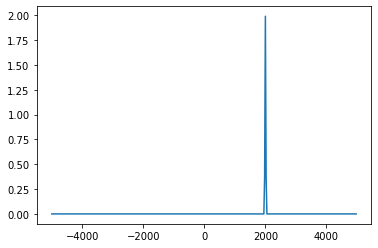

In [16]:
def windowed_fft(wfm, comp_for_demod_loss=True):
    num_samps = len(wfm.y)
    
    # Apply window
    window = np.hamming(num_samps)
    y_windowed = np.multiply(window, wfm.y)
    
    # Calculate FFT and shift it so frequency bins are in order
    fft = np.fft.fftshift(np.fft.fft(y_windowed, len(y_windowed)))

    # Scale the fft by the number of elements and by the window. Also scale
    # by sqrt(2) to compensate for loss of half of the signal energy when
    # low-pass filtering during IQ demodulation.
    window_coherent_gain = 0.54
    scaling = 1.0 / (len(fft) * window_coherent_gain)
    if comp_for_demod_loss:
        scaling *= np.sqrt(2)
    fft *= scaling
    
    # Calculate the bin information
    df = (1.0/wfm.dt) / num_samps
    f0 = -(num_samps / 2.0) * df
    return Spectrum(f0, df, fft)

def convert_spectrum_to_volts_squared(spectrum):
    v_squared = np.real(spectrum.y)**2 + np.imag(spectrum.y)**2
    return Spectrum(spectrum.f0, spectrum.df, v_squared)


spectrum = windowed_fft(wfm)
spectrum_volts_squared = convert_spectrum_to_volts_squared(spectrum)
plt.plot(spectrum_volts_squared.frequency_bins(), spectrum_volts_squared.y)

Peak freq = [2000.], ampl = [15.9963907]


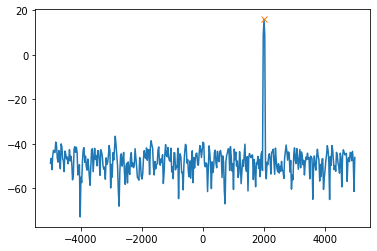

In [17]:
def convert_spectrum_to_dbm(spectrum):
    """
    Note: assumes 50 Ohms
    """
    volts_squared = convert_spectrum_to_volts_squared(spectrum)
    dbv = 10*np.log10(volts_squared.y)
    dbm = dbv + 30 - 10*np.log10(50)
    return Spectrum(spectrum.f0, spectrum.df, dbm)

spectrum_dbm = convert_spectrum_to_dbm(spectrum)
bins = spectrum_dbm.frequency_bins()
plt.plot(bins, spectrum_dbm.y)
peak_index, _ = signal.find_peaks(spectrum_dbm.y, height=-20)
peak_freq = bins[peak_index]
peak_ampl = spectrum_dbm.y[peak_index]
print("Peak freq = {}, ampl = {}".format(peak_freq, peak_ampl))
plt.plot(peak_freq, peak_ampl, 'x')

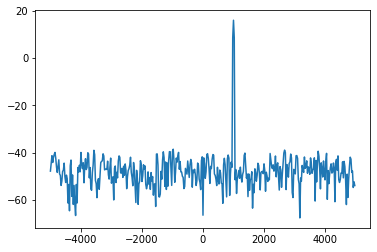

In [18]:
def frequency_shift(wfm, shift):
    tone = create_single_tone(1.0/wfm.dt, wfm.dt * len(wfm.y), shift)
    y = wfm.y * tone.y
    return Waveform(wfm.t0, wfm.dt, y)

tone = create_single_tone(sample_rate, duration, tone_freq)
noise = create_noise_signal(sample_rate, duration, 0.01)
wfm = tone + noise
shifted = frequency_shift(wfm, -1000)
spectrum = windowed_fft(shifted)
spectrum_dbm = convert_spectrum_to_dbm(spectrum)
plt.plot(spectrum_dbm.frequency_bins(), spectrum_dbm.y)

In [23]:
def create_dual_tone(sample_rate, duration, tone_freq):
    dt = 1/sample_rate
    t = np.arange(0, duration, dt)
    tone = np.sin(2*np.pi*tone_freq*t)
    return Waveform(0, dt, tone)

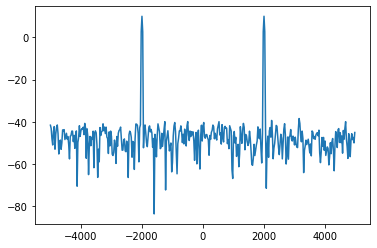

In [25]:
tone = create_dual_tone(sample_rate, duration, tone_freq)
noise = create_noise_signal(sample_rate, duration, 0.01)
wfm = tone + noise
spectrum = windowed_fft(wfm)
spectrum_dbm = convert_spectrum_to_dbm(spectrum)
plt.plot(spectrum_dbm.frequency_bins(), spectrum_dbm.y)